In [1]:
import pandas as pd
from typing import List
import os

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 15
})

import pandas as pd
import os


DATA = {
        "m":            [],
        "delta_p":      [],
        "p_hat":        [],
        "p_min":        [],
        "pi":           [],
        "k":            [],
        "l":            [],
        "search_bound": [],
        "n":            [],
        "i":            [],
        "cls":          [],
    }

# m;delta_p;p_hat;p_min;pi;k;l;bound;n
def read(from_: str) -> pd.DataFrame:
    files = os.listdir(from_)
    for file in files:
        fs = file.split("_")
        i, cls = float(fs[0].split("-")[-1]), fs[-2]
        with open(os.path.join(from_, file), "r") as f:
            data = next(f.readlines()[-2:].__iter__(), "").rstrip().split(";")
            if len(data) > 1:
                n, bound, pi, delta_p, l, k, p_min, p_hat, m  = (
                    float(data[-1]), float(data[-2]), 
                    float(data[-5]), float(data[1]),
                    float(data[-3]), float(data[-4]),
                    float(data[-6]), float(data[-7]), float(data[0])
                )
                DATA["m"].append(m)
                DATA["p_min"].append(p_min)
                DATA["p_hat"].append(p_hat)
                DATA["l"].append(l)
                DATA["k"].append(k)
                DATA["pi"].append(pi)
                DATA["delta_p"].append(delta_p)
                DATA["search_bound"].append(bound)
                DATA["n"].append(n)
                DATA["i"].append(i)
                DATA["cls"].append(cls)
    return pd.DataFrame(DATA)

In [2]:
# uncomment designated D, T
#D, T= "out-s1-3-10000-600", "$\quad\quad m=2$"+"$\quad \hat{p} = 0 \quad P_{\mathrm{min}} = 0.9$"
#D, T= "out-s2-3-10000-600", "$\quad\quad m=2$"+"$\quad \hat{p} = 0.3 \quad P_{\mathrm{min}} = 0.9$"
#D, T= "out-s3-3-10000-600", "$\quad\quad m=2$"+"$\quad \hat{p} = 0.7 \quad P_{\mathrm{min}} = 0.9$"
D, T= "out-s4-3-10000-600", "$\quad\quad m=2$"+"$\quad \hat{p} = 0.9 \quad P_{\mathrm{min}} = 0.9$"
df = read("../out/"+D)

from math import exp, log, ceil

def find_bound_1(bound_2: int, delta_p: float, pi: float) -> int:
    r = (1-p_min) / (m-1)
    for n in range(1, ceil(bound_2)+1):
        l = (
            p_hat * exp(-0.5 * n * (delta_p**2) * ((1-pi)**2))
        ) + (
            (1-p_hat) * exp(-0.5 * n * ((delta_p * (1-pi)-pi)**2)) 
        ) 
        v = l <= r
        if v:
            return n
    return 0

df.sort_values(
    by=["i","pi","delta_p"], 
    inplace=True, 
    ignore_index=True
)
df.loc[df.n < 1, "n"] = 1

m, p_min, p_hat = df.m.mean(), df.p_min.mean(), df.p_hat.mean()


df = df.assign(
    explicit_bound= lambda x: 
        (2 / 
         ((x.delta_p * (1-x.pi) - x.pi)**2)
        ) * (log((m-1) / (1-p_min)))
)
df["implicit_bound"] = df.apply(
    lambda x: find_bound_1(x.explicit_bound, x.delta_p, x.pi), axis=1
)
df1, df2, df3, df4 = (
    df[df.cls == "0.0"],
    df[df.cls == "0.3"],
    df[df.cls == "0.6"],
    df[df.cls == "0.9"],
)

In [3]:
df.to_csv("../csvs/"+D+".csv")
df

,m,delta_p,p_hat,p_min,pi,k,l,search_bound,n,i,cls,explicit_bound,implicit_bound
0,2.0,0.04,0.9,0.9,0.000000,10000.0,3.0,3745.0,539.0,1.0,0.0,2878.231366,2879
1,2.0,0.04,0.9,0.9,0.011538,10000.0,3.0,4214.0,588.0,1.0,0.3,5873.941765,3234
2,2.0,0.04,0.9,0.9,0.023077,10000.0,3.0,5872.0,680.0,1.0,0.6,17988.948198,4061
3,2.0,0.04,0.9,0.9,0.034615,10000.0,3.0,41063.0,813.0,1.0,0.9,287823.343857,6875
4,2.0,0.08,0.9,0.9,0.000000,10000.0,3.0,936.0,140.0,2.0,0.0,719.557842,720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.0,0.96,0.9,0.9,0.440816,10000.0,3.0,84.0,3.0,24.0,0.9,499.692404,30
96,2.0,1.00,0.9,0.9,0.000000,10000.0,3.0,6.0,1.0,25.0,0.0,4.605170,5
97,2.0,1.00,0.9,0.9,0.150000,10000.0,3.0,9.0,1.0,25.0,0.3,9.398307,7
98,2.0,1.00,0.9,0.9,0.300000,10000.0,3.0,15.0,2.0,25.0,0.6,28.782314,12


### avg factor explicit bound
0.0: 5.4226199522398
0.3: 8.626664314238772
0.6: 17.90778275838509
0.9: 198.7899485404527
### avg factor implicit bound
0.0: 5.562404219143715
0.3: 5.75918610019056
0.6: 5.538594054481272
0.9: 7.81396757240523


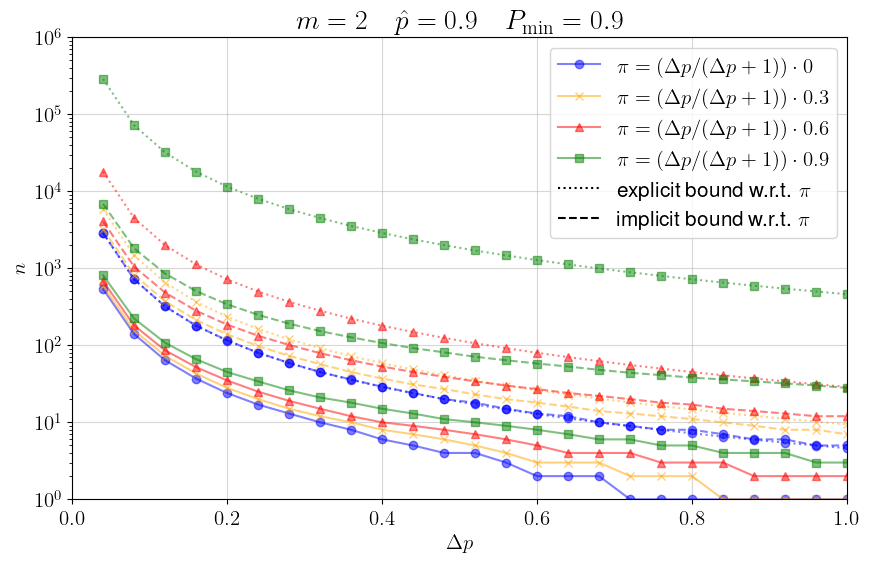

In [4]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(
    df1.delta_p, df1.n, "blue", 
    label="$\pi =(\Delta p / (\Delta p + 1)) \cdot 0$", 
    marker="o", alpha=0.5
)
ax.plot(
    df1.delta_p, df1["explicit_bound"],
    "blue", alpha=0.5, 
    linestyle="dotted", marker="o"
)
ax.plot(
    df1.delta_p, df1["implicit_bound"],
    "blue", alpha=0.5,
    linestyle="dashed", marker="o"
)

ax.plot(
    df2.delta_p, df2.n, "orange", 
    label="$\pi =(\Delta p / (\Delta p + 1)) \cdot 0.3$", 
    marker="x", alpha=0.5
)
ax.plot(
    df2.delta_p, df2["explicit_bound"],
    "orange", alpha=0.5,
    linestyle="dotted", marker="x"
)
ax.plot(
    df2.delta_p, df2["implicit_bound"],
    "orange", alpha=0.5, 
    linestyle="dashed",marker="x"
)

ax.plot(
    df3.delta_p, df3.n, "red", 
    label="$\pi = (\Delta p / (\Delta p + 1)) \cdot 0.6$", 
    marker="^", alpha=0.5
)
ax.plot(
    df3.delta_p, df3["explicit_bound"],"red", 
    alpha=0.5, linestyle="dotted",
    marker="^"
)
ax.plot(
    df3.delta_p, df3["implicit_bound"],
    "red", alpha=0.5, linestyle="dashed", marker="^"
)


ax.plot(
    df4.delta_p, df4.n, 
    "green", label="$\pi = (\Delta p / (\Delta p + 1)) \cdot 0.9$", 
    marker="s", alpha=0.5
)
ax.plot(
    df4.delta_p, df4["explicit_bound"],
    "green", alpha=0.5, linestyle="dotted",marker="s")
ax.plot(
    df4.delta_p, df4["implicit_bound"],
    "green", alpha=0.5, linestyle="dashed", marker="s"
)

ax.plot([],[], label="explicit bound w.r.t. $\pi$",
    color="black",linestyle="dotted")
ax.plot([],[],label="implicit bound w.r.t. $\pi$",
    color="black",linestyle="dashed")

plt.xlim(0, 1)
plt.ylim(1, 10**6)
plt.yscale("log")
plt.legend()
plt.xlabel("$\Delta p$")
plt.ylabel("$n$")
plt.title(
T,
size=20) 
plt.grid(alpha=.5)
#plt.tight_layout()
plt.savefig(f"../plots/{D}_s.pdf")



bound = "explicit_bound"
print("### avg factor explicit bound")
print(f"0.0: {(df1[bound] / df1.n).mean()}")
print(f"0.3: {(df2[bound] / df2.n).mean()}")
print(f"0.6: {(df3[bound] / df3.n).mean()}")
print(f"0.9: {(df4[bound] / df4.n).mean()}")

bound = "implicit_bound"
print("### avg factor implicit bound")
print(f"0.0: {(df1[bound] / df1.n).mean()}")
print(f"0.3: {(df2[bound] / df2.n).mean()}")
print(f"0.6: {(df3[bound] / df3.n).mean()}")
print(f"0.9: {(df4[bound] / df4.n).mean()}")

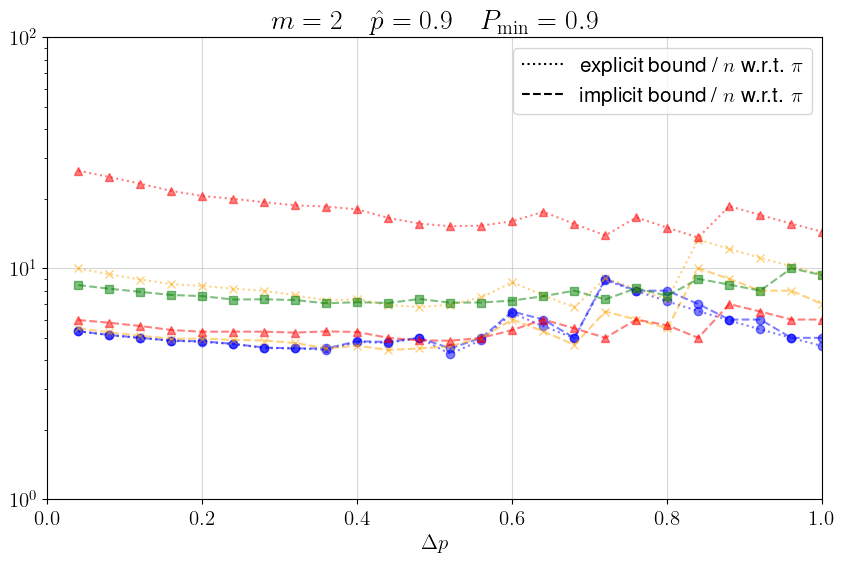

In [5]:
fig, ax = plt.subplots(figsize=(10,6))  

ax.plot(df1.delta_p, df1["explicit_bound"] / df1.n, 
"blue", 
linestyle="dotted", marker="o",
alpha=0.5)
ax.plot(df1.delta_p, df1["implicit_bound"] / df1.n,"blue", 
    alpha=0.5,
    linestyle="dashed", marker="o"
   )
ax.plot(df2.delta_p, df2["explicit_bound"] / df2.n, 
"orange", 
linestyle="dotted", marker="x",
alpha=0.5)
ax.plot(df2.delta_p, df2["implicit_bound"] / df2.n,"orange", 
    alpha=0.5,
    linestyle="dashed", marker="x"
   )
ax.plot(df3.delta_p, df3["explicit_bound"] / df3.n, 
"red", 
linestyle="dotted", marker="^", 
alpha=0.5)
ax.plot(df3.delta_p, df3["implicit_bound"] / df3.n,"red", 
    alpha=0.5,
    linestyle="dashed", marker="^"
   )
ax.plot(df4.delta_p, df4["explicit_bound"] / df4.n, 
"green", 
linestyle="dotted", marker="s",
alpha=0.5)
ax.plot(df4.delta_p, df4["implicit_bound"] / df4.n,"green", 
    alpha=0.5,
    linestyle="dashed", marker="s"
   )
ax.plot([],[],label="explicit bound / $n$ w.r.t. $\pi$",
    color="black",linestyle="dotted")
ax.plot([],[],label="implicit bound / $n$ w.r.t. $\pi$",
    color="black",linestyle="dashed")

plt.xlim(0, 1)
plt.ylim(1, 10**2)
plt.yscale("log")
plt.xlabel("$\Delta p$")
plt.legend()
plt.title(T,
size=20)
plt.grid(alpha=.5)
#plt.tight_layout()
plt.savefig(f"../plots/{D}_sf.pdf")